In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

(<matplotlib.image.AxesImage at 0x1a7b3a0e288>, Text(0.5, 1.0, 'Input image'))

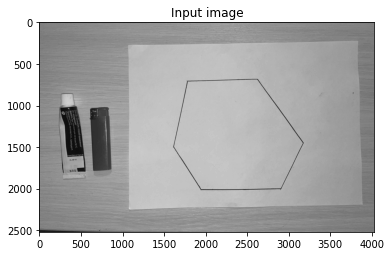

In [100]:
img = cv2.imread("../sources/input/01True.jpg")
# img = cv2.imread("../sources/input/11False.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# do some noise reduction
d = 3
g_sigmaColor = 10
g_sigmaSpace = 10
gray = cv2.bilateralFilter(gray, d, g_sigmaColor, g_sigmaSpace)
plt.imshow(gray, cmap="gray"), plt.title(f"Input image")

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1a7b69872c8>)

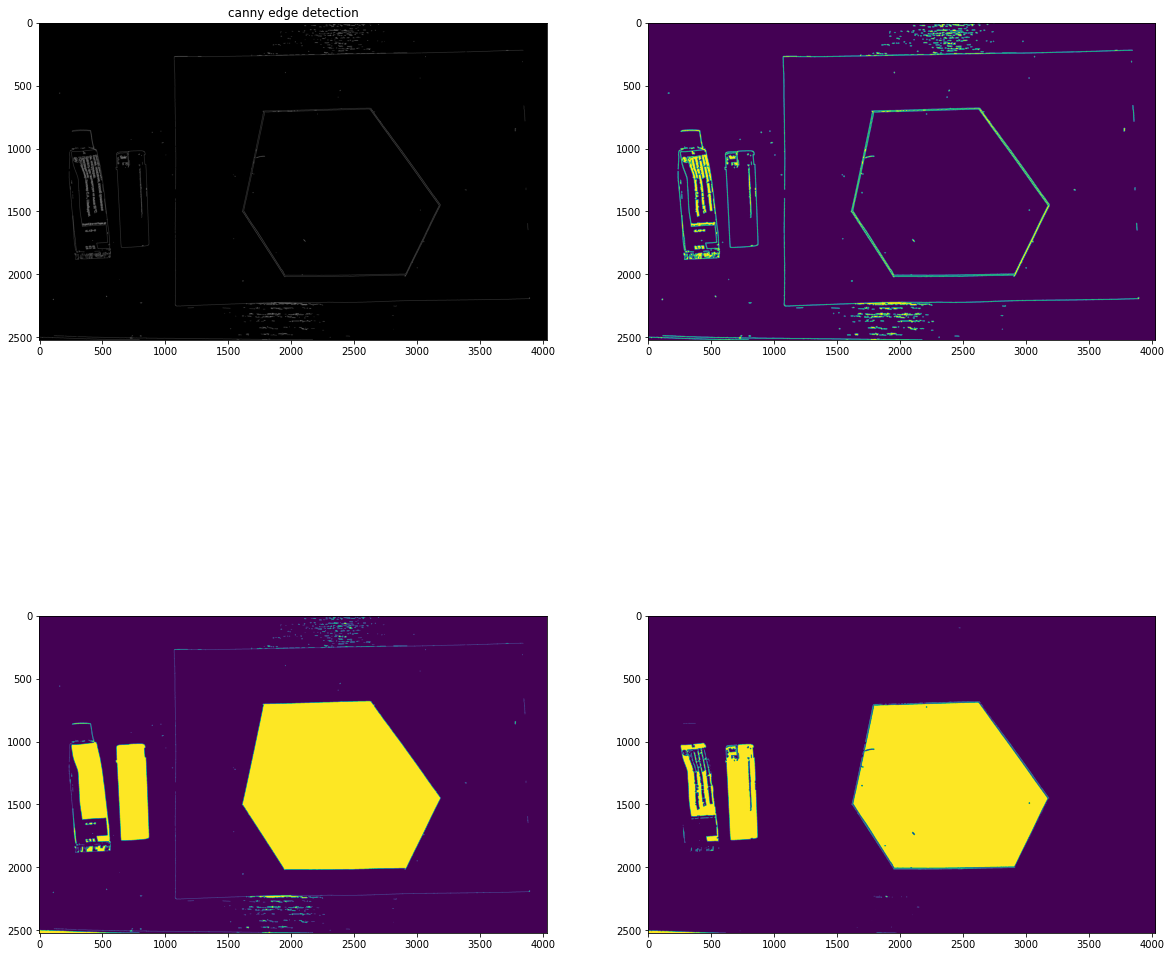

In [101]:
        # now detect edges and floodfill the binary image, dilation allows joining edges with holes
        edges = cv2.Canny(gray, 100, 200)  # works
        im_th = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=1)
        im_floodfill = im_th.copy()
        
        # Mask used to flood filling.
        # Notice the size needs to be 2 pixels than the image.
        h, w = im_th.shape[:2]
        mask = np.zeros((h+2, w+2), np.uint8)

        # Floodfill from point (0, 0)
        cv2.floodFill(im_floodfill, mask, (0, 0), 255)
        # Invert floodfilled image
        im_floodfill_inv = cv2.bitwise_not(im_floodfill)
        # Combine the two images to get the foreground.
        im_out =  im_th | im_floodfill_inv

        kernel = np.ones((5, 5), np.uint8)
        im_out = cv2.erode(im_out, kernel, iterations=1)
        plt.figure(figsize=(20,20))
        plt.subplot(2, 2, 1),plt.imshow(edges, cmap="gray"), plt.title(f"canny edge detection")
        plt.subplot(2, 2, 2),plt.imshow(im_th)
        plt.subplot(2, 2, 3),plt.imshow(im_out)
        plt.subplot(2, 2, 4),plt.imshow(im_floodfill_inv)
        

area brightness: 157.65891966702998
area brightness: 157.65891966702998
area brightness: 157.65891966702998
area brightness: 157.65891966702998
area brightness: 184.7589722495899
area brightness: 184.7589722495899
area brightness: 184.7589722495899
area brightness: 184.7589722495899
area brightness: 35.510019824499395
area brightness: 35.510019824499395
area brightness: 35.510019824499395
area brightness: 35.510019824499395
area brightness: 60.00532740882047
area brightness: 60.00532740882047
area brightness: 60.00532740882047
area brightness: 60.00532740882047


(<AxesSubplot:title={'center':'Final object'}>,
 Text(0.5, 1.0, 'Final object'))

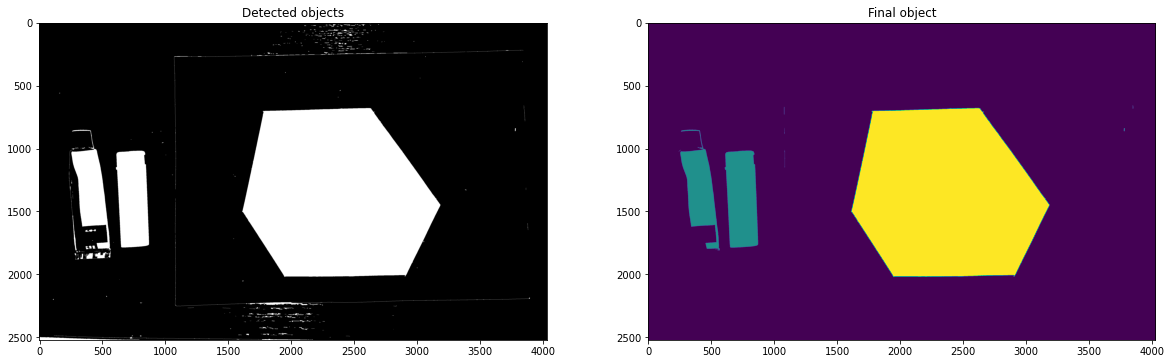

In [102]:
        # Extract objects using connected component labeling
        n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(im_out, connectivity=4)

        # Create false color image
        colors = np.arange(0, 200, 200 / n_labels).astype(np.uint8)
        colors[0] = 0  
        false_colors = colors[labels]

        max_br = 0
        num_objects = 0
        area_thr = 0.4
        whole_area = im_out.shape[0] * im_out.shape[1]
        brightest_color = 0
        for i in range(len(colors)):
            object_area = np.sum(false_colors == colors[i])
#             print(object_area / whole_area * 100, "Remove:", object_area < whole_area * area_thr / 100)
            if object_area < whole_area * area_thr / 100:
                false_colors[false_colors == colors[i]] = 0
            else:
                num_objects += 1
                print("area brightness:", np.mean(gray[false_colors == colors[i]]))
                cur_br = np.mean(gray[false_colors == colors[i]])
                if colors[i] != 0 and cur_br > max_br:
                    max_br = cur_br
                    brightest_color = colors[i]

        false_colors[false_colors == brightest_color] = 255  # colorize drawn area with the brightest color
        false_colors[np.logical_and(false_colors != 255, false_colors > 0)] = 128  # colorize objects to fit into area
        plt.figure(figsize=(20,20))
        plt.subplot(2, 2, 1),plt.imshow(im_out, cmap="gray"), plt.title(f"Detected objects")
        plt.subplot(2, 2, 2), plt.imshow(false_colors), plt.title(f"Final object")
       

In [103]:
# check whether the object fits into marked area
marked_area_coords = np.argwhere(false_colors == 255)
area_crop_coords = (np.min(marked_area_coords[:, 0]),
                    np.min(marked_area_coords[:, 1]),
                    np.max(marked_area_coords[:, 0]),
                    np.max(marked_area_coords[:, 1]))

object_area_coords = np.argwhere(false_colors == 128)
object_crop_coords = (np.min(object_area_coords[:, 0]),
                        np.min(object_area_coords[:, 1]),
                        np.max(object_area_coords[:, 0]),
                        np.max(object_area_coords[:, 1]))

area = false_colors[area_crop_coords[0]:area_crop_coords[2], area_crop_coords[1]:area_crop_coords[3]]
object = false_colors[object_crop_coords[0]:object_crop_coords[2], object_crop_coords[1]:object_crop_coords[3]]

object_fits_in_area = False
source_area = np.sum(area > 0)
print("object.shape" ,object.shape,"area.shape", area.shape )
if np.all(np.less(object.shape, area.shape)):
    for i in range(area.shape[0] - object.shape[0]):
        for j in range(area.shape[1] - object.shape[1]):
            # put object in coords (i,j) over area
            tmp_area = area.copy()
            tmp_area[i:i+object.shape[0], j:j+object.shape[1]][object > 0] = object[object > 0]
            new_area = np.sum(tmp_area > 0)
            
            if new_area <= source_area:
                object_fits_in_area = True
                break
        if object_fits_in_area:
            break
print("Predicted value:", object_fits_in_area)


object.shape (975, 3537) area.shape (1357, 2768)
Predicted value for objects fit inside area: False
